# **앙상블 기법을 활용한 안개 발생 예측 모델 개발**

- 참가번호: 240486
- 팀명: 밤안갱

---

## 1. 데이터 로딩

### 1-1. 데이터 설명

- 컬럼

    - `Year` : 년도
    - `Month` : 월
    - `Day` : 일
    - `Time` : 시간 (0 ~ 23)
    - `Minute` : 분 (10분 단위)
    - `STN_ID` : 지점 번호
    - `WS10(deg)` : 10분 평균 풍향, 단위: deg
    - `WS10(m/s)` : 10분 평균 풍속, 단위: m/s
    - `TA` : 1분 평균 기온 10분 주기, 단위: C
    - `RE` : 강수 유무 (0:무강수, 1:강수)
    - `HM` : 1분 평균 상대 습도 10분 주기, 단위: %
    - `sun10` : 1분 일사량 10분단위 합계, 단위: MJ
    - `TS` : 1분 평균 지면온도 10분 주기, 단위: C
    - `VIS1` : 1분 평균 시정 10분 주기, 단위: C (VIS1 변수는 시정 구간을 알 수 있는 변수로 검증 데이터에서는 제외)
    - `class` : 시정 구간

- 시정 계급 기준 (비고: 안개의 기준)

    - `1` : 0 < 시정 < 200
    - `2` : 200 <= 시정 < 500
    - `3` : 500 <= 시정 < 1000
    - `4` : 1000 <= 시정


### 1-2. 모듈 불러오기

In [1]:
import os
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, make_scorer

import warnings
warnings.filterwarnings(action='ignore')

pd.set_option("display.max_columns", None)
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False


### 1-3. 데이터 불러오기

In [2]:
def get_local_path(train_dataset_name, test_dataset_name):

    # 작업 디렉토리 origin_dir에 선언
    origin_dir = os.getcwd()
    
    # 후속 작업을 위해 임시적으로 상위 디렉토리로 이동
    os.chdir("..")

    # fog_data 폴더 생성
    os.makedirs("fog_data", exist_ok=True)

    # 데이터셋 경로 설정
    train_path = os.path.join(os.getcwd(), "fog_data", train_dataset_name)
    # val_path = os.path.join(os.getcwd(), "fog_data", val_dataset_name)
    test_path = os.path.join(os.getcwd(), "fog_data", test_dataset_name)

    # 운영체제가 윈도우일 경우 "\\"를 "/"로 처리
    if os.name == "nt":
        train_path = train_path.replace("\\", "/")
        # val_path = val_path.replace("\\", "/")
        test_path = test_path.replace("\\", "/")

    # 원래의 디렉토리로 경로 초기화
    os.chdir(origin_dir)

    return train_path, test_path

In [3]:
train_path, test_path = get_local_path("fog_train.csv", "fog_test.csv")

train_df = pd.read_csv(train_path, index_col=0).rename(columns=lambda x: x.split('.')[1]).reset_index(drop=True)
test_df = pd.read_csv(test_path, index_col=0).rename(columns=lambda x: x.split('.')[1]).reset_index(drop=True)

In [4]:
# train / validation 분리에 앞서, target 변수의 결측치를 미리 제거
def drop_nan_in_target(df, col):
    df[col] = df[col].replace({-99:np.nan, -99.9:np.nan})
    # train 데이터셋의 hm 컬럼에 0인 값이 1개 존재 → 이상치로 판단하여 삭제한다
    df['hm'] = df['hm'].replace(0, np.nan)
    dropped = df.dropna()
    return dropped

train_df = drop_nan_in_target(train_df, "class")

In [5]:
# train, validation 분리
train_df, val_df = train_test_split(train_df, random_state=42, train_size=0.75, stratify=train_df["class"])

---

## 2. 데이터 전처리

### 2-1. 기존 컬럼 수정
- `stn_id` 컬럼이 마스킹되어 있어, 정확한 지역 및 지점을 알 수 없다.
    - 따라서, Train 데이터셋과 Test 데이터셋에 **동일하게 나타나는 지역 특성에 해당하는 문자만 남기고 지점에 해당하는 문자는 지운다**
    - 지역 특성에 따라 5개 지역으로 구분 (내륙, 내륙산악, 동해안, 서해안, 남해안 / A, B, C, D, E)
- `hm` 컬럼에 0으로 표시된 데이터가 하나 존재 한다
    - 상대습도가 0일 수는 없기 때문에, 해당 데이터를 제거한다

In [6]:
# 컬럼 수정 및 제거 함수
def modify_columns(train_df, val_df, test_df):

    # stn_id 수정 : A, B, C, D, E로 수정
    train_df["stn_id"] = train_df["stn_id"].apply(lambda x: x[0])
    val_df["stn_id"] = val_df["stn_id"].apply(lambda x: x[0])
    test_df["stn_id"] = test_df["stn_id"].apply(lambda x: x[0])


    train_df["re"] = train_df["re"].astype("int")
    val_df["re"] = val_df["re"].astype("int")
    test_df["re"] = test_df["re"].astype("int")

    # hm = 0인 데이터 index 찾아서 drop
    hm_zero_idx = train_df[train_df['hm'] == 0].index
    train_df.drop(hm_zero_idx, inplace=True)

    return train_df, val_df, test_df

In [7]:
train_df, val_df, test_df = modify_columns(train_df, val_df, test_df)

### 2-1. 파생 컬럼 생성

#### 2-1-1. 기온-지면 온도 차

- 안개는 급격한 온도 변화 시 지면이 빠르게 냉각되어 발생하는 것이 일반적이다. 
- 이를 감지하기 위해 **기온과 지면 온도의 차이**를 나타내는 파생 변수를 생성한다.

In [8]:
def temp_diff(df):
    df["temp_diff"] = df["ta"] - df["ts"]
    return df

In [9]:
train_df = temp_diff(train_df)
val_df = temp_diff(val_df)
test_df = temp_diff(test_df)

#### 2-1-2. 이슬점

- 안개와 **이슬점** 사이에는 밀접한 관계가 있다
    - 본 분석에서는 안개를 식별하기 위한 파생 변수로 **이슬점**을 생성하여 활용한다. 
- 분석의 용이를 위해, **이슬점 도달 여부**와 **습수** 파생 변수를 추가로 생성한다.

In [10]:
# 이슬점 생성 함수
def calculate_dew_point(T, RH):

    # T : 기온, RH : 상대 습도

    # b = 17.27
    # c = 237.7
    b = 17.62
    c = 234.12

    gamma = (b * T) / (c + T) + np.log(RH / 100.0)
    dew_point = (c * gamma) / (b - gamma)

    return dew_point

In [11]:
train_df["dew_point"] = calculate_dew_point(train_df['ta'], train_df['hm'])
val_df["dew_point"] = calculate_dew_point(val_df['ta'], val_df['hm'])
test_df["dew_point"] = calculate_dew_point(test_df['ta'], test_df['hm'])

In [12]:
# 이슬점 도달 여부 함수
def diff_ts_dew(df, ts, dew_point):
    # 기온 - 이슬점 <= 0, 이슬점 온도보다 기온이 낮다는 뜻
    df["dew_reached"] = df.apply(lambda x: 1 if (x[ts] - x[dew_point] <= 0) else 0, axis=1)

    return df       

In [13]:
train_df = diff_ts_dew(train_df, "ts", "dew_point")
val_df = diff_ts_dew(val_df, "ts", "dew_point")
test_df = diff_ts_dew(test_df, "ts", "dew_point")

In [14]:
# 습수 계산 함수
def make_t_td(df, ta, dew_point):
    df["t_td"] = df[ta] - df[dew_point]
    return df

In [15]:
train_df = make_t_td(train_df, "ta", "dew_point")
val_df = make_t_td(val_df, "ta", "dew_point")
test_df = make_t_td(test_df, "ta", "dew_point")

#### 2-1-3. 풍향

- 풍향은 0° ~ 360°의 척도로 나타나는데, 이때 북쪽은 0°와 360°의 두 가지로 표현되는 문제가 발견되었다.
- 정확한 분석을 위해 `ws10_deg`가 360°인 데이터를 **0°로 변환**해 주는 과정을 수행한다.

In [16]:
# 풍향 360인 것 0으로 변경
def switch_wind_degree(df, col):
    df[col] = df[col].apply(lambda x: 0 if x==360 else x)
    return df

In [17]:
train_df = switch_wind_degree(train_df, "ws10_deg")
val_df = switch_wind_degree(val_df, "ws10_deg")
test_df = switch_wind_degree(test_df, "ws10_deg")

#### 2-1-4. 안개 여부
- class 1 ~ 3 : 안개 발생
- class 4 : 안개가 끼지 않음
- 안개 여부에 해당하는 컬럼 (`is_fog`)을 새로 생성한다

In [18]:
# 안개 여부 컬럼 생성
def is_fog(df, column):
    df["is_fog"] = df[column].apply(lambda x: 0 if x > 3 else 1)
    return df

In [19]:
train_df = is_fog(train_df, "class")
val_df = is_fog(val_df, "class")
test_df = is_fog(test_df, "class")

### 2-2. 탐색적 데이터 분석 (EDA)

#### 2-2-1. 안개 유무에 따른 상대 습도
- 안개가 발생했을 때, 상대 습도 (`hm`)가 확연하게 높은 것을 확인할 수 있다.

In [20]:
# 안개 유무에 따른 상대 습도 비교
def hm_by_column(df, column="is_fog"):
    fig, axes = plt.subplots(ncols=2, figsize=(8, 8))

    for i in range(2):
        fog_hm = df[df[column] == i]['hm']
        axes[i].boxplot(
            # 데이터의 결측치는 -99 or -99.9로 표시되어 있기 때문에, 상대습도가 0 이상인 것으로 조건을 설정
            fog_hm[fog_hm >= 0]
        )
        title = ("안개가 낀 경우" if i else "평상시") + " 상대 습도"
        axes[i].set_title(title)
        axes[i].set_yticks([i for i in range(0, 101, 10)])

    plt.show()

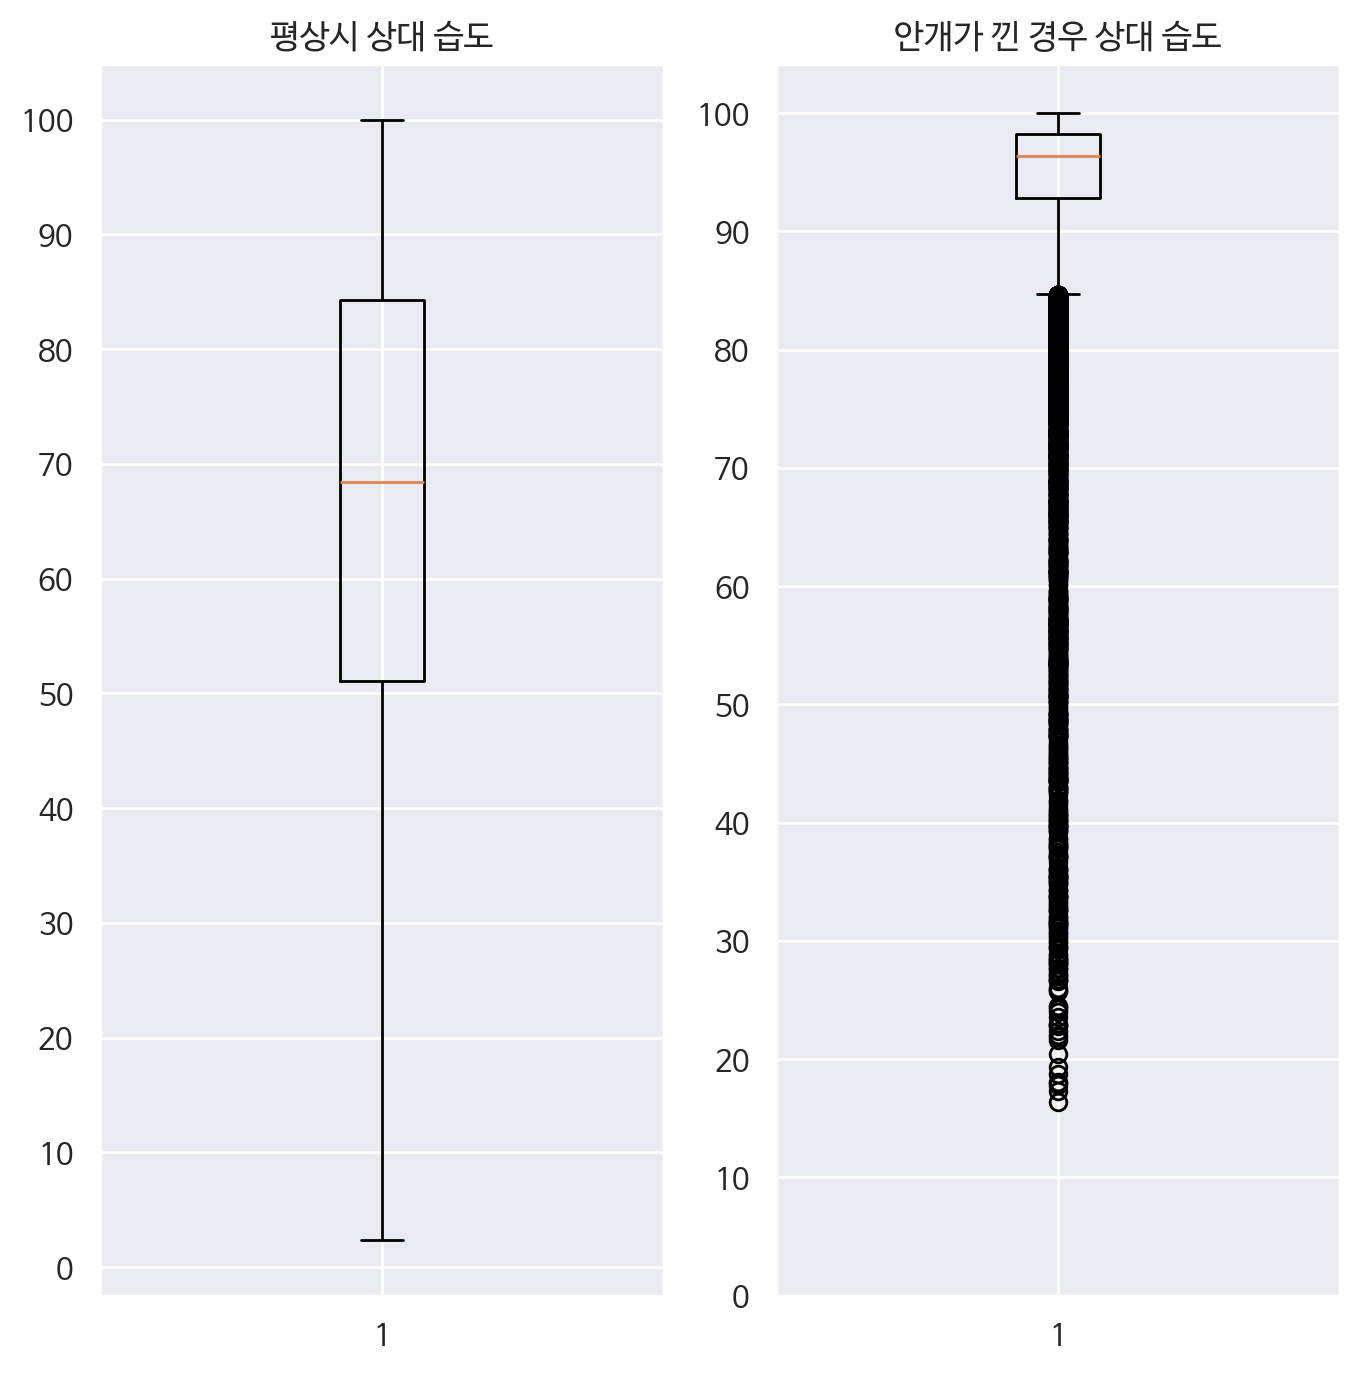

In [21]:
hm_by_column(train_df)

#### 2-2-2. 표준편차 기반 이상치 확인
- 월별 기온과 지면의 온도차 (`temp_diff`)를 시각화하여 확인하였다.
    - $\pm3\sigma$를 이상치의 경계로 잡고, 붉은 선으로 히스토그램과 함께 시각화하였다.
    - 시각화 결과, 월별 이상치가 다소 존재하는 것을 확인하였다.

In [22]:
# 표준편차 기반 이상치 확인 (3 std) 
def outliers_check_monthly(df, df_name, column, criteria="month"):

    # 결측치 (-99, -99.9) 때문에, temp_diff 컬럼의 값이 커지게 된다
    # 따라서, 시각화를 위해 -99, -99.9인 데이터를 drop하고, 남은 데이터셋으로 시각화를 진행
    df_copy = df.copy()
    df_copy = df_copy.replace({-99:np.nan, -99.9:np.nan})
    df_copy = df_copy.dropna()

    # 서브플롯 생성
    fig, axes = plt.subplots(4, 3, figsize=(15, 20))
    axes = axes.flatten()

    # month에 대해 반복
    unique_values = np.unique(df_copy[criteria])
    if criteria == "month":
        unique_values = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2]
    for idx, val in enumerate(unique_values):
        ax = axes[idx]

        mon_cond = (df_copy[criteria] == val)
        mon_mean = np.mean(df_copy[mon_cond][column])
        std_minus_3 = mon_mean - 3 * np.std(df_copy[mon_cond][column])
        std_plus_3 = mon_mean + 3 * np.std(df_copy[mon_cond][column])

        # 히스토그램 생성
        sns.histplot(data=df_copy[mon_cond], 
                    x=column, 
                    kde=True, 
                    hue="stn_id",
                    hue_order=["A", "B", "C", "D", "E"],
                    ax=ax)

        # 평균선 추가
        ax.axvline(mon_mean, color='b', linestyle='--', linewidth=1)
                #    label='Mean')

        # 표준편차 기준 -3~3 범위선 추가
        ax.axvline(std_minus_3, color='r', linestyle='--', linewidth=1)
                #    , label='-3 Std Dev')
        ax.axvline(std_plus_3, color='r', linestyle='--', linewidth=1)
                #    , label='+3 Std Dev')

        ax.set_title(f"Outliers in {column} per month {val} in {df_name}")
        # ax.legend()

    # 빈 subplot 삭제
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])


    plt.tight_layout()
    plt.show()

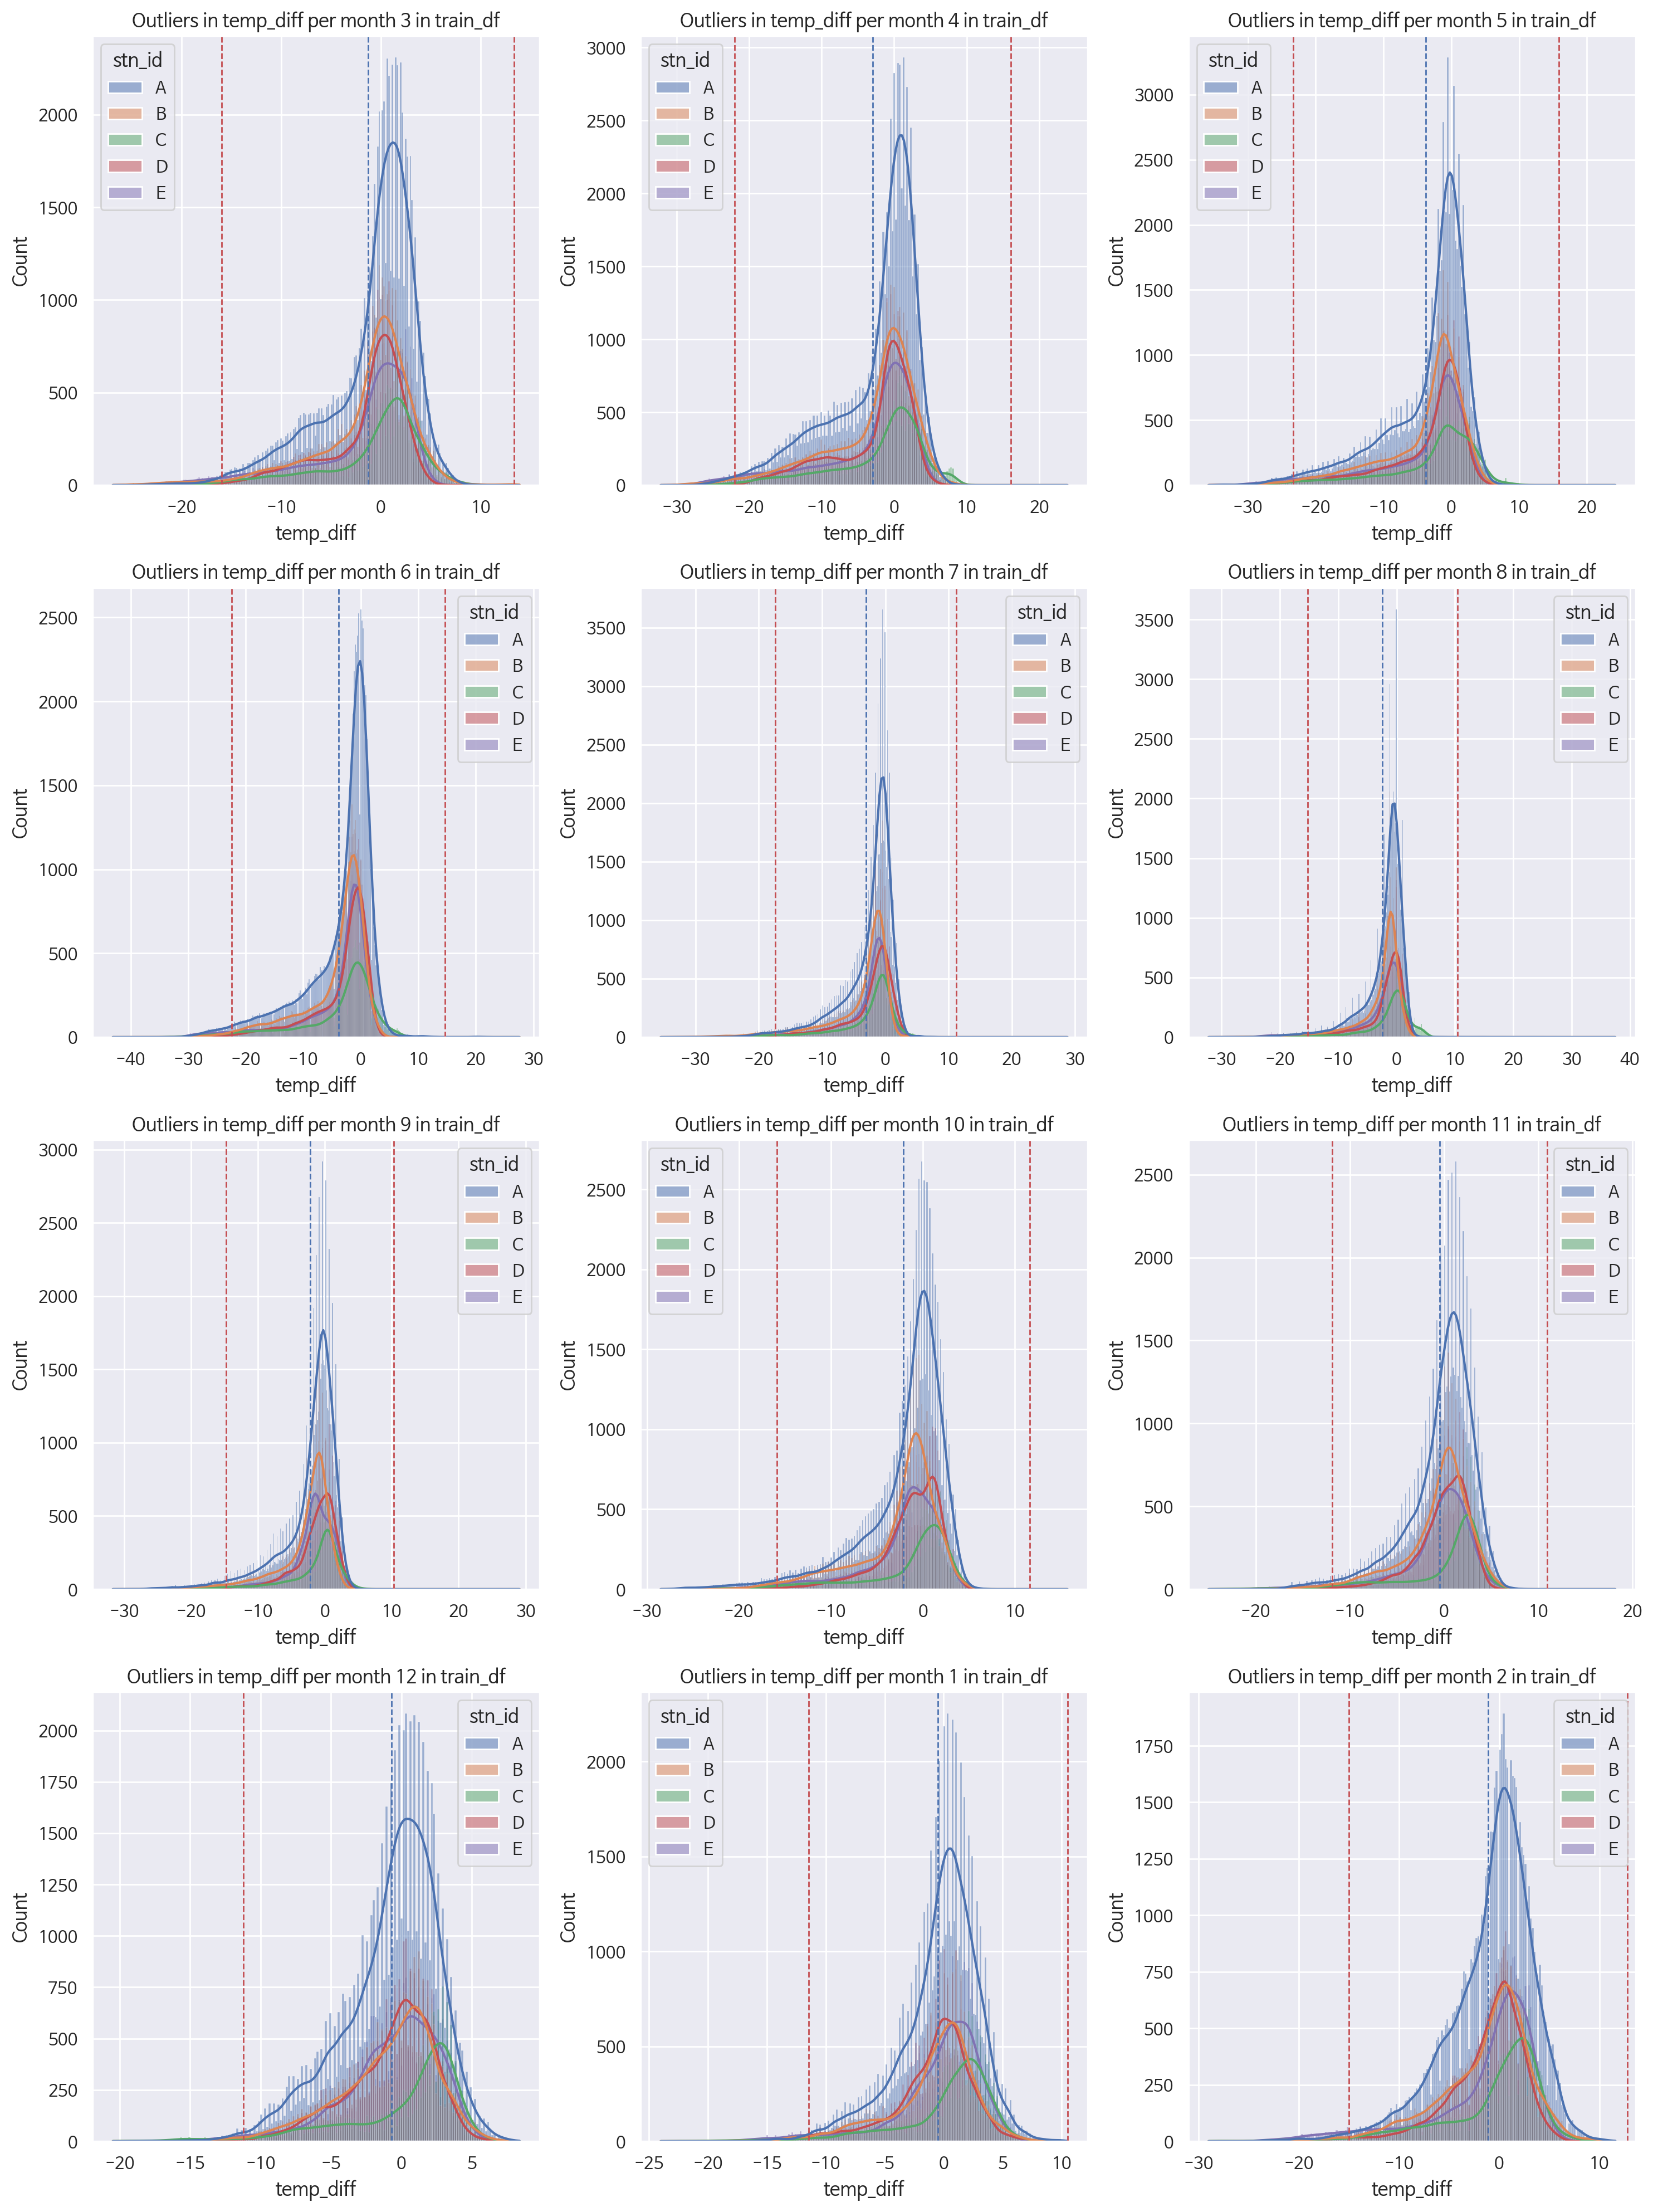

In [23]:
outliers_check_monthly(train_df, "train_df", "temp_diff")

#### 2-2-3. 월별 `stn_id`에 따른 안개 발생 비율 측정
- 각각의 월별, `stn_id`에 따라 안개 발생 비율을 측정하여, 지역별 차이점을 발견하였다.
    - 가을과 겨울에 A와 B 지역에서 안개 발생 빈도가 상대적으로 많이 증가하였다.
- 이를 감안한다면, `stn_id`에 따라 서로 다른 예측 모델이 적용될 필요성도 있어 보였다.

In [26]:
# 월별, 관측소별 안개 유무 비율 확인
def fog_rate_by_month_and_stn(df, col):
    month_df = df.groupby(["month", "stn_id"])[col].value_counts().to_frame()

    # 월별 안개가 낀 빈도수 계산하여 month_fog_tot_num에 선언
    month_fog_tot_num = df[df[col]==1].groupby(["month"])["stn_id"].count().to_frame()
    month_fog_tot_num = month_fog_tot_num.rename(columns={"stn_id":"tot_cnts"}).reset_index()

    ,# month_df에서 안개가 낀 데이터만 가져옴
    month_is_fog = month_df.reset_index()[month_df.reset_index()[col] == 1]

    # month 별 stn_id의 비율을 구하기 위해 month_fot_tot_num 데이터프레임과 merge
    month_is_fog = month_is_fog.merge(month_fog_tot_num)
    month_is_fog["stn_rate"] = month_is_fog["count"] / month_is_fog["tot_cnts"]

    # month, stn_id 컬럼 순으로 정렬
    month_is_fog = month_is_fog.sort_values(["month", "stn_id"])
    month_is_fog["stn_rate"] = month_is_fog["stn_rate"].apply(lambda x: np.round(x*100, 2))

    # 결측치 비율 시각화
    plt.figure(figsize=(15, 7))

    sns_pct = sns.barplot(x="month", 
                        y="stn_rate", 
                        hue="stn_id", 
                        data=month_is_fog)

    # bar 그래프 상단에 비율 (%) 표기
    for bar in sns_pct.patches:
        height = bar.get_height()                      # bar의 높이를 가져옴
        if height > 0:                                 # 높이가 0보다 클 때만 텍스트를 추가
            plt.text(bar.get_x() + bar.get_width()/2,  # 글자 위치 x좌표
                    height + 0.5,                   # 글자 위치 y좌표
                    "%.1f" % height,                  # 소수점 셋째 자리까지 비율 표시
                    ha="center")                      # 가운데 정렬

    # 시각화 제목 이름, 폰트 크기 지정
    sns_pct.set_title("Fog Value Distribution (%) for stn_id Column by Month in Train Dataset", fontsize=15)
    plt.tight_layout()
    # plt.show()

    # lineplot 생성
    plt.figure(figsize=(15, 7))

    # 라인 플롯 생성
    sns_pct = sns.lineplot(x="month", 
                        y="stn_rate", 
                        hue="stn_id", 
                        data=month_is_fog,
                        marker='o')  # 포인트에 마커 추가

    # 라인 플롯의 각 포인트에 값 표시
    for line in sns_pct.lines:
        for x, y in zip(line.get_xdata(), line.get_ydata()):
            if y > 0:  # 높이가 0보다 클 때만 텍스트 추가
                plt.text(x, y + 0.5, f"{y:.1f}", ha="center")

    # 불필요한 범례 항목 제거
    handles, labels = sns_pct.get_legend_handles_labels()
    filtered_handles = [handle for handle, label in zip(handles, labels) if label != '4']
    filtered_labels = [label for label in labels if label != '4']

    # 시각화 제목과 폰트 크기 지정
    sns_pct.set_title("Fog Distribution (%) for month by class in Train Dataset with Lineplot", fontsize=15)
    sns_pct.legend(filtered_handles, filtered_labels, title='stn_id')

    plt.tight_layout()
    plt.show()

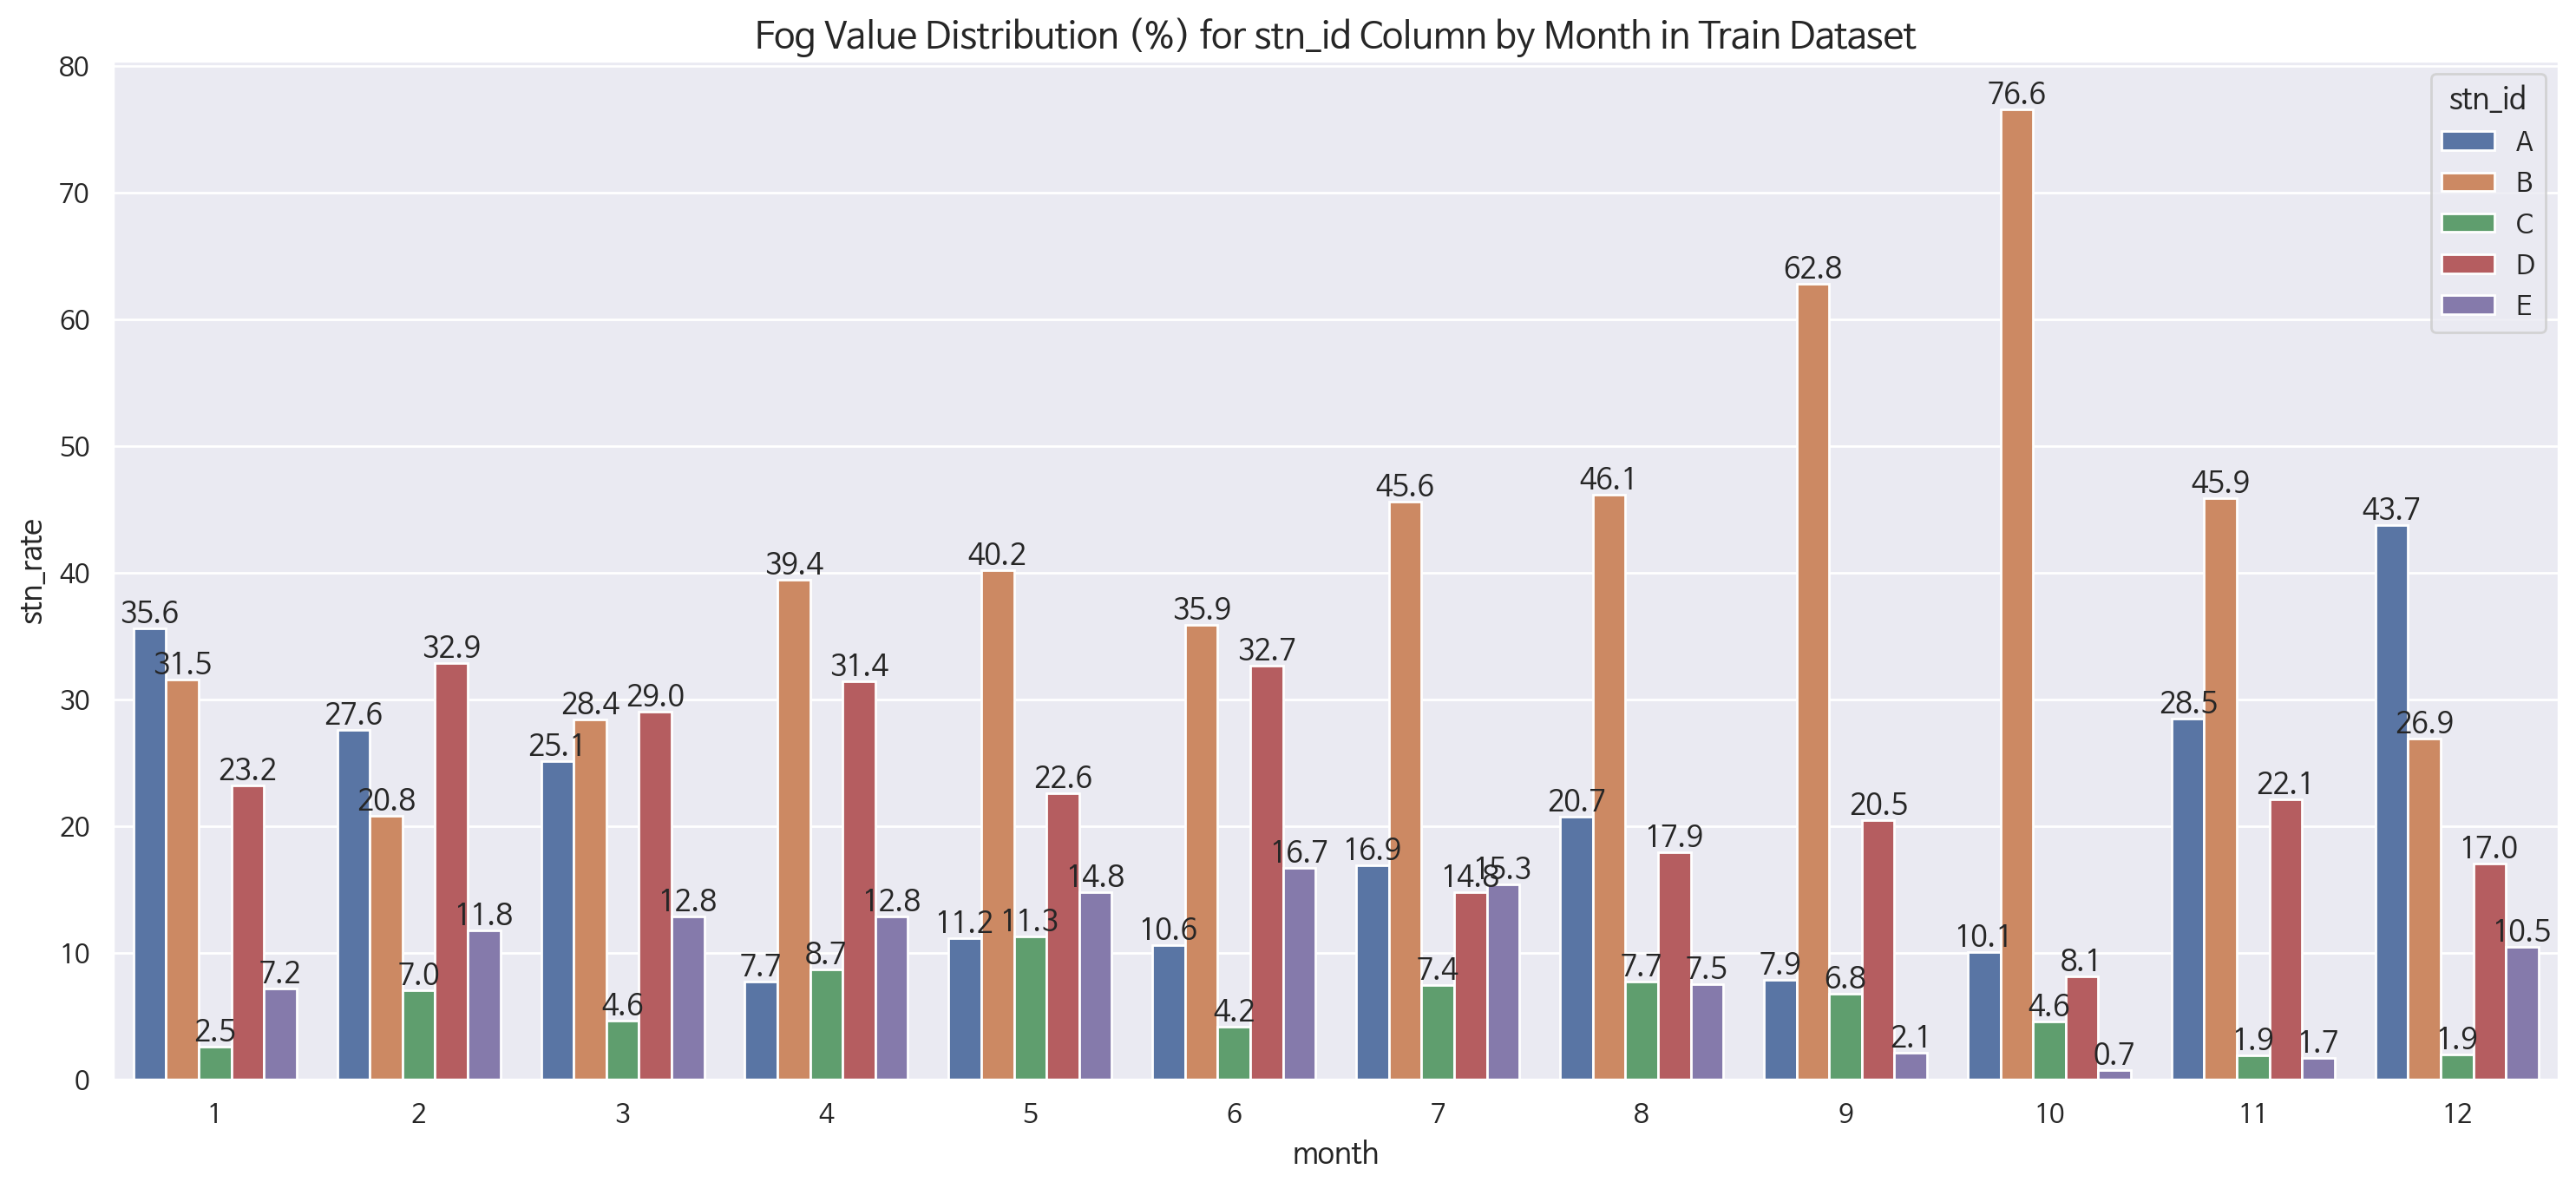

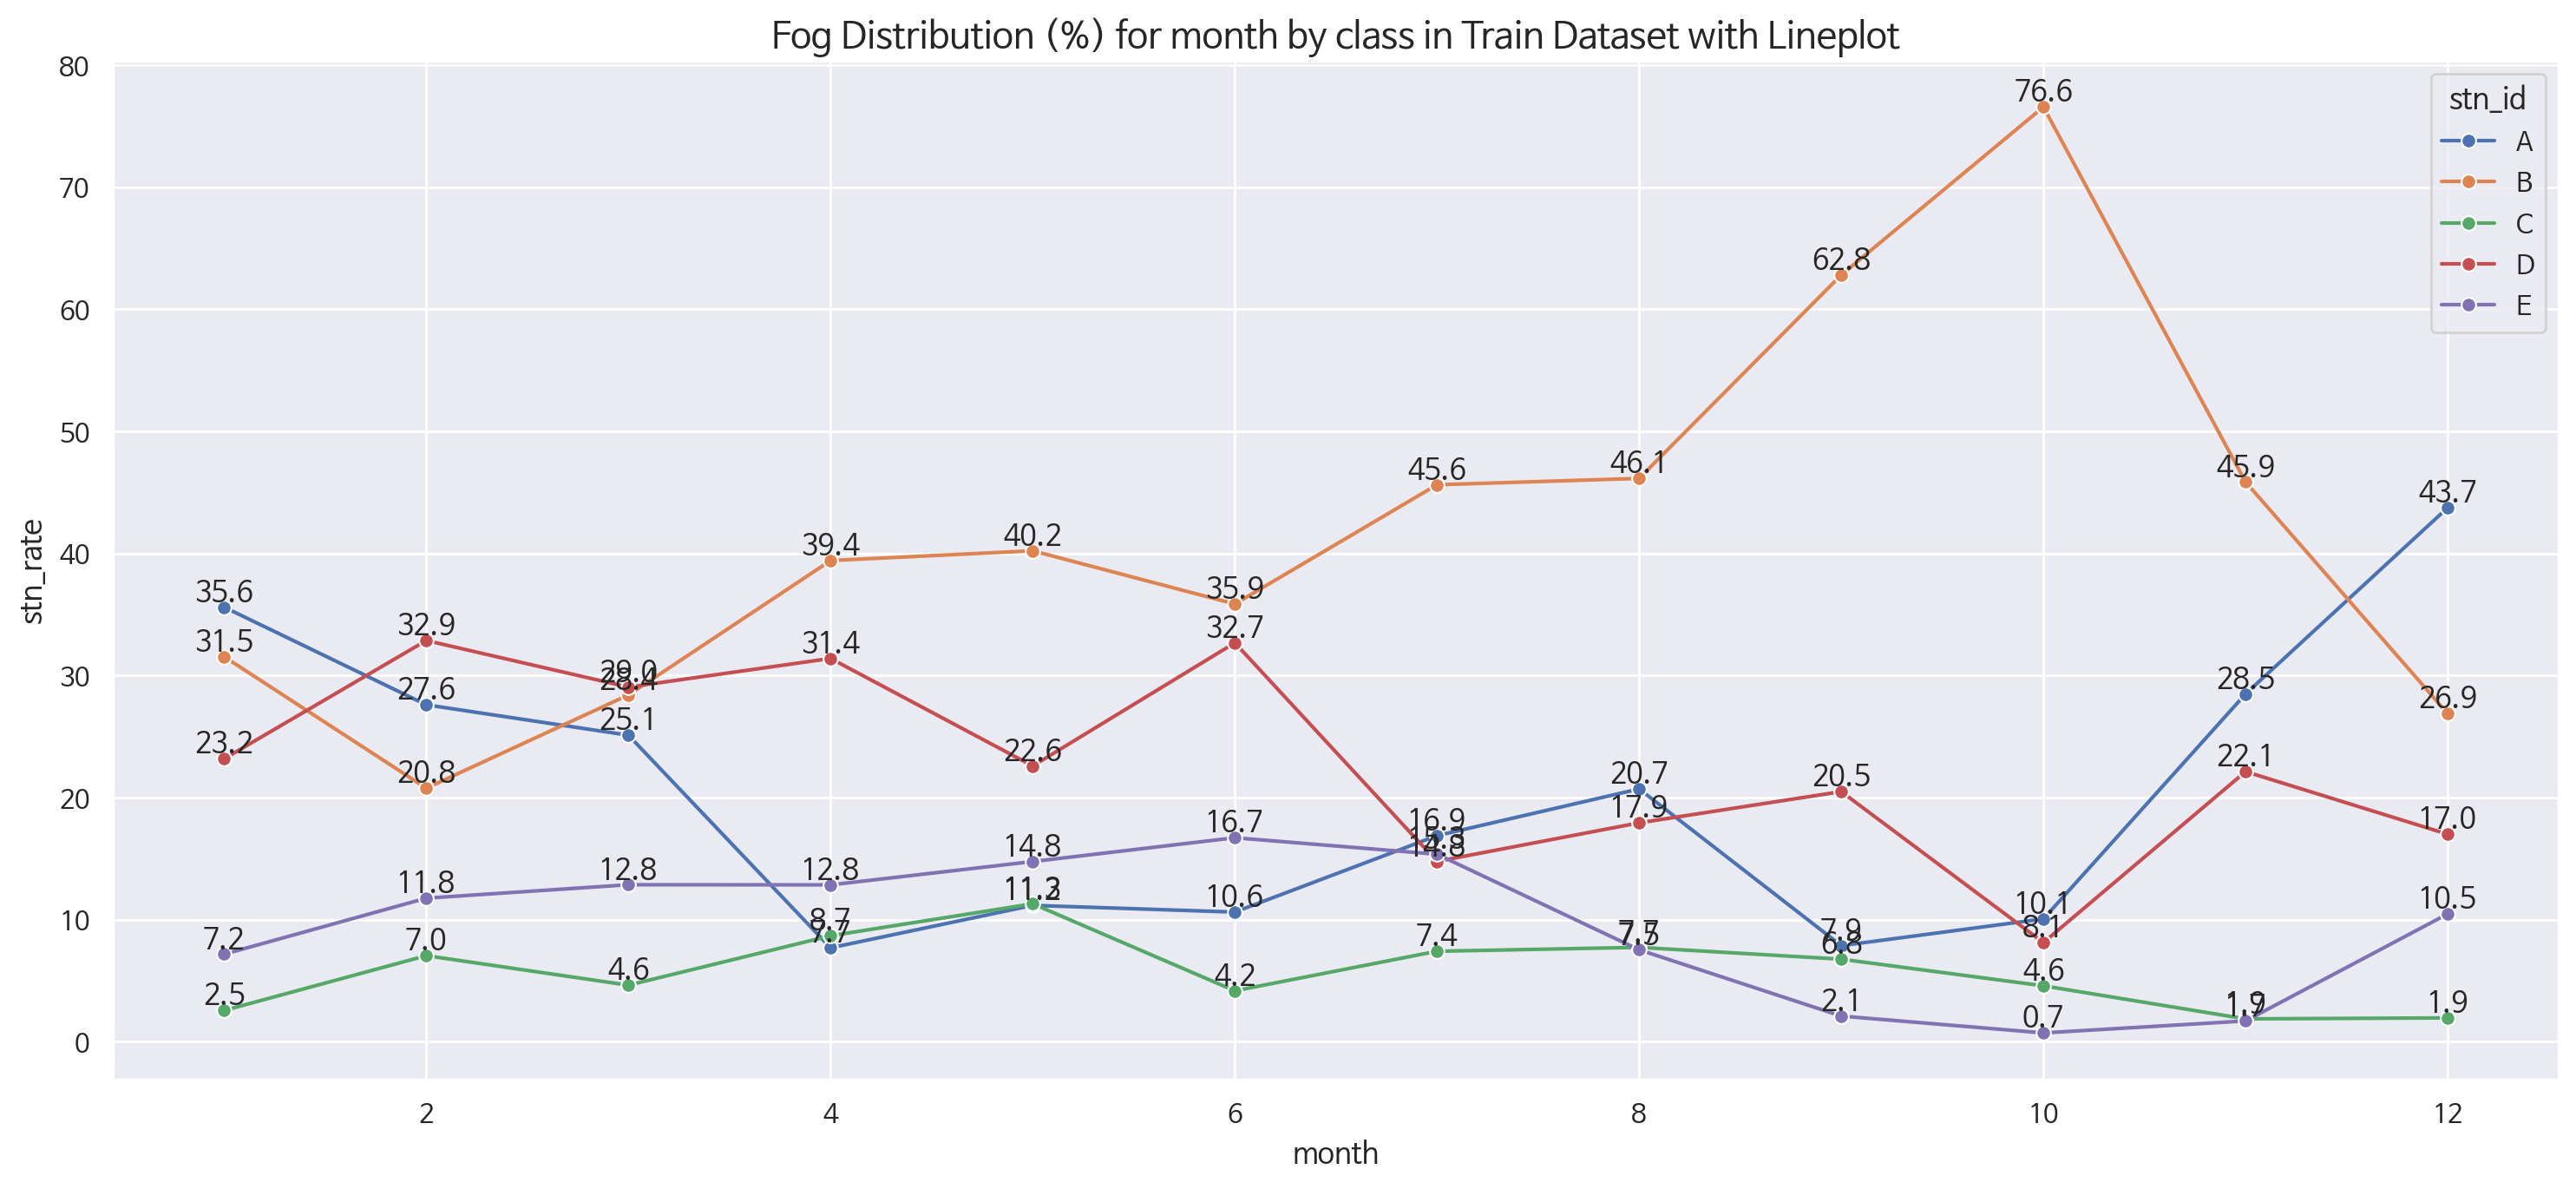

In [27]:
fog_rate_by_month_and_stn(train_df, "is_fog")

### 2-2. 이상치 처리

- 탐색적 분석을 진행해 본 결과, 기상 이변 및 관측 오류로 인한 **이상치**가 모델에 불리하게 작용할 수 있음을 확인하였다. 
- 따라서 본 분석에서는 월별, 지역별 이상치를 감지한 뒤 이를 **캡핑**(capping)하는 처리 과정을 진행한다. 
    - 이때 제한 범위의 기준은 $\pm3\sigma$로 결정한다.

In [28]:
def detect_and_replace_outliers_month_stn(df, columns, threshold=3):
    df_copy = df.copy()

    for column in columns:
        # month 및 stn_id 별로 groupby 후, 평균 및 표준편차 계산
        stats = df_copy.groupby(['month', 'stn_id'])[column].agg(['mean', 'std'])
        stats['lower_bound'] = stats['mean'] - threshold * stats['std']
        stats['upper_bound'] = stats['mean'] + threshold * stats['std']

        # df_copy 데이터프레임에 stats 데이터프레임을 merge
        df_copy = df_copy.merge(stats[['lower_bound', 'upper_bound']], left_on=['month', 'stn_id'], right_index=True)

        # 범위를 벗어나는 값들을 대체한다
        df_copy[column] = df_copy.apply(
            lambda row: max(row['lower_bound'], min(row['upper_bound'], row[column])), axis=1
        )

        # lower_bound, upper_bound 컬럼 제거
        df_copy.drop(columns=['lower_bound', 'upper_bound'], inplace=True)

    return df_copy

In [29]:
train_df = detect_and_replace_outliers_month_stn(train_df, ["temp_diff", "ta", "ts"])
val_df = detect_and_replace_outliers_month_stn(val_df, ["temp_diff", "ta", "ts"])
test_df = detect_and_replace_outliers_month_stn(test_df, ["temp_diff", "ta", "ts"])

### 2-3. 결측치 처리

- 탐색적 분석 과정에서, 관측 오류에 따른 **결측치**를 식별하였다. 
- 본 분석에서는 값이 `-99` 또는 `-99.9`인 데이터를 월별, 지역별 **평균으로 대체**하는 작업을 수행한다.

In [31]:
# train, val, test 데이터셋에서 -99, -99.9 포함한 컬럼 확인
train_cols_na = train_df.columns[train_df.isna().any()].tolist()
val_cols_na = val_df.columns[val_df.isna().any()].tolist()
test_cols_na = test_df.columns[test_df.isna().any()].tolist()

In [32]:
# 결측치 대체 함수
def fill_missing_values_with_monthly_mean(df, na_columns):

    df_filled = df.copy()

    # month, stn_id로 groupby 한 후 na_columns별로 각각 평균을 구한다
    grouped_means = df.groupby(['month', 'stn_id'])[na_columns].transform('mean')

    # na_columns별 결측치를 각 컬럼들의 평균로 대체한다
    for column in na_columns:
        df_filled[column] = df_filled[column].fillna(grouped_means[column])

    return df_filled

In [33]:
# 결측치 대체 처리 (month, stn_id별 각 컬럼의 평균으로 대체)
train_df = fill_missing_values_with_monthly_mean(train_df, train_cols_na)
val_df = fill_missing_values_with_monthly_mean(val_df, val_cols_na)
test_df = fill_missing_values_with_monthly_mean(test_df, test_cols_na)

### 2-4. 데이터셋 분리

- 본 분석에서는 이진 분류 후 다중 분류를 진행하는의 앙상블 모델을 개발하고자 한다. 
- 이에 따라, train, validation, test 데이터셋을 각 모델에 투입할 수 있도록 **별도로 선언**해 주는 과정을 수행한다.

In [34]:
# 이진 분류에 사용할 train, validation, test 데이터셋 선언

# target 컬럼
target_binary = "is_fog"

# 모델 생성시 사용할 컬럼 선택
used_cols_binary = ["month", "time", "stn_id", "ta", "ts", "temp_diff", "hm",
                    "re", "ws10_ms", "sun10", "dew_reached", "t_td", "ws10_deg"]

X_train_binary = train_df[used_cols_binary]
y_train_binary = train_df[target_binary]

X_val_binary = val_df[used_cols_binary]
y_val_binary = val_df[target_binary]

X_test_binary = test_df[used_cols_binary]

In [35]:
X_train_binary.shape, X_val_binary.shape, y_train_binary.shape, y_val_binary.shape, X_test_binary.shape

((2350456, 13), (783486, 13), (2350456,), (783486,), (262800, 13))

In [36]:
# 다중 분류에 사용할 train, validation, test 데이터셋 선언

# target 컬럼
target_multiclassification = "class"

# 모델 생성시 사용할 컬럼 지정
used_cols_multiclassification = ["month", "time", "stn_id", "ta", "ts", "temp_diff", "hm",
                                 "re", "ws10_ms", "sun10", "dew_reached",  "t_td", "ws10_deg"]


X_train_mc = train_df[used_cols_multiclassification]
y_train_mc = train_df[target_multiclassification]

X_val_mc = val_df[used_cols_multiclassification]
y_val_mc = val_df[target_multiclassification]

X_test_mc = test_df[used_cols_multiclassification]

In [37]:
X_train_mc.shape, X_val_mc.shape, y_train_mc.shape, y_val_mc.shape, X_test_mc.shape

((2350456, 13), (783486, 13), (2350456,), (783486,), (262800, 13))

---

## 3. 분류 모델 학습 및 예측
- 모델링 플로우 차트 <br>

![모델링 플로우 차트](https://i.imgur.com/eGKHxHF.png)

- `target` 변수의 비율과 안개 발생 빈도에 대한 월별, 지역별 특성을 반영하여 두 가지 모델을 합친 **Ensemble** 모델을 개발한다.
    1. 이진 분류 모델 생성
        - 안개 여부 (`is_fog`)를 우선 학습하고 예측한다.
    2. 다중 분류 모델 생성
        - 안개가 낄 것으로 예측한 데이터와 기존 데이터를 바탕으로, 안개의 시정 계급 (`class`)를 예측한다.

### 3-1. 모델 생성을 위한 범주형 데이터 인코딩
- 모델에 투입할 컬럼 중 `stn_id`의 **Label Encoding**을 수행한다.

In [38]:
# stn_id를 각각 1 ~ 5로 정한 딕셔너리 생성
stn_id_map = {"A" : 1,
              "B" : 2,
              "C" : 3,
              "D" : 4,
              "E" : 5}

# stn_id_map을 바탕으로 stn_id 컬럼 mapping
X_train_binary["stn_id"] = X_train_binary["stn_id"].map(stn_id_map)
X_val_binary["stn_id"] = X_val_binary["stn_id"].map(stn_id_map)
X_test_binary["stn_id"] = X_test_binary["stn_id"].map(stn_id_map)

In [39]:
# stn_id_map을 바탕으로 stn_id 컬럼 mapping
X_train_mc["stn_id"] = X_train_mc["stn_id"].map(stn_id_map)
X_val_mc["stn_id"] = X_val_mc["stn_id"].map(stn_id_map)
X_test_mc["stn_id"] = X_test_mc["stn_id"].map(stn_id_map)

### 3-2. 평가 지표 생성
- 모델 평가 지표 생성
    - 다중 CSI (Critical Success Index : 임계 성공 지수)
$$ CSI = \frac{H}{H+M+F} $$
$$ H: Hit,\quad F: False\ Alarm, \quad M: Miss $$

In [41]:
# CSI 지수 함수 생성
def csi_index(y_true, y_pred):

    model_cm = confusion_matrix(y_true, y_pred)

    H = (model_cm[0][0] + model_cm[1][1] + model_cm[2][2])
    F = (model_cm[0][1] + model_cm[0][2] +
            model_cm[1][0] + model_cm[1][2] +
            model_cm[2][0] + model_cm[2][1] +
            model_cm[3][0] + model_cm[3][1] + model_cm[3][2])
    M = (model_cm[0][3] + model_cm[1][3] + model_cm[2][3])

    model_csi = H / (H + F + M)

    return model_csi

csi_scorer = make_scorer(csi_index, greater_is_better=True)

### 3-3. 모델 개발

#### 3-3-1. 이진 분류 모델

- **안개의 발생 여부**를 의미하는 `is_fog`를 예측하는 **이진 분류 모델**을 개발한다. 
    - 이때 **랜덤포레스트**를 활용한다.

In [60]:
def binary_rf(X_train_binary, y_train_binary, X_val_binary, y_val_binary, X_test_binary):
    stn_list = range(1, 6)

    # X_val_binary 데이터셋을 stn_id에 맞게 정렬
    X_val_binary_sorted = X_val_binary.sort_values('stn_id')
    y_val_binary_sorted = y_val_binary.loc[X_val_binary_sorted.index]

    # X_train_binary, X_val_binary, X_test_binary index로 된 Series 선언
    y_train_pred_df = pd.Series(index=X_train_binary.index, dtype=float)
    y_val_pred_df = pd.Series(index=X_val_binary.index, dtype=float)
    y_test_pred_df = pd.Series(index=X_test_binary.index, dtype=float)

    # Random Forest 분류 모델 생성
    models = {i: RandomForestClassifier(max_features="sqrt",
                                        max_depth=50,
                                        random_state=42) for i in stn_list}

    cm_binary = {}

    # 관측소별 for 문
    for i in stn_list:
        # 관측소 별로 해당하는 index를 train_binary 데이터에서 뽑아온다
        now_idx_train = X_train_binary[X_train_binary['stn_id'] == i].index
        now_idx_val = X_val_binary_sorted[X_val_binary_sorted['stn_id'] == i].index
        now_idx_test = X_test_binary[X_test_binary['stn_id'] == i].index

        # 관측소별 index에 해당하는 X_train_binary, y_train_binary 데이터로 모델 학습
        columns=X_train_binary.columns
        models[i].fit(X_train_binary.loc[now_idx_train, columns], y_train_binary.loc[now_idx_train])

        # 관측소별 index에 맞게 학습한 모델로 y_train, y_val, y_test 예측한 값 선언
        y_val_pred_now = models[i].predict(X_val_binary_sorted.loc[now_idx_val, columns])
        y_test_pred_now = models[i].predict(X_test_binary.loc[now_idx_test, columns])

        # 값이 비어있는 Series에 모델로 예측한 값을 index에 맞게 채워 넣는다
        y_val_pred_df.loc[now_idx_val] = y_val_pred_now
        y_test_pred_df.loc[now_idx_test] = y_test_pred_now

        # confusion matrix 생성
        cm_binary[i] = confusion_matrix(y_val_binary_sorted[now_idx_val], y_val_pred_now)

    return y_val_pred_df, y_test_pred_df, cm_binary, models

In [61]:
y_val_pred_rf, y_test_pred_rf, cm_binary, models_binary = binary_rf(X_train_binary, y_train_binary, X_val_binary, y_val_binary, X_test_binary)
confusion_matrix(y_val_binary, y_val_pred_rf)

array([[774950,    502],
       [  4140,   3894]], dtype=int64)

##### 3-3-1-1. 이진 분류 결과 및 시각화
- 실제 안개가 발생한 값 (`is_fog` = 1) 중 약 0.48%를 안개가 발생한 것으로 예측 (**Recall = 0.48%**)
- 안개가 발생하지 않은 데이터 자체가 대다수이기 때문에, Accuracy는 의미가 없다.

In [62]:
print("이진 분류 모델의 Recall:", recall_score(y_val_binary, y_val_pred_rf))
print("이진 분류 모델의 Precision:", precision_score(y_val_binary, y_val_pred_rf))
# print("이진 분류 모델의 Accuracy:", accuracy_score(y_val_binary, y_val_pred_rf))


이진 분류 모델의 Recall: 0.48469006721433905
이진 분류 모델의 Precision: 0.8858052775250227


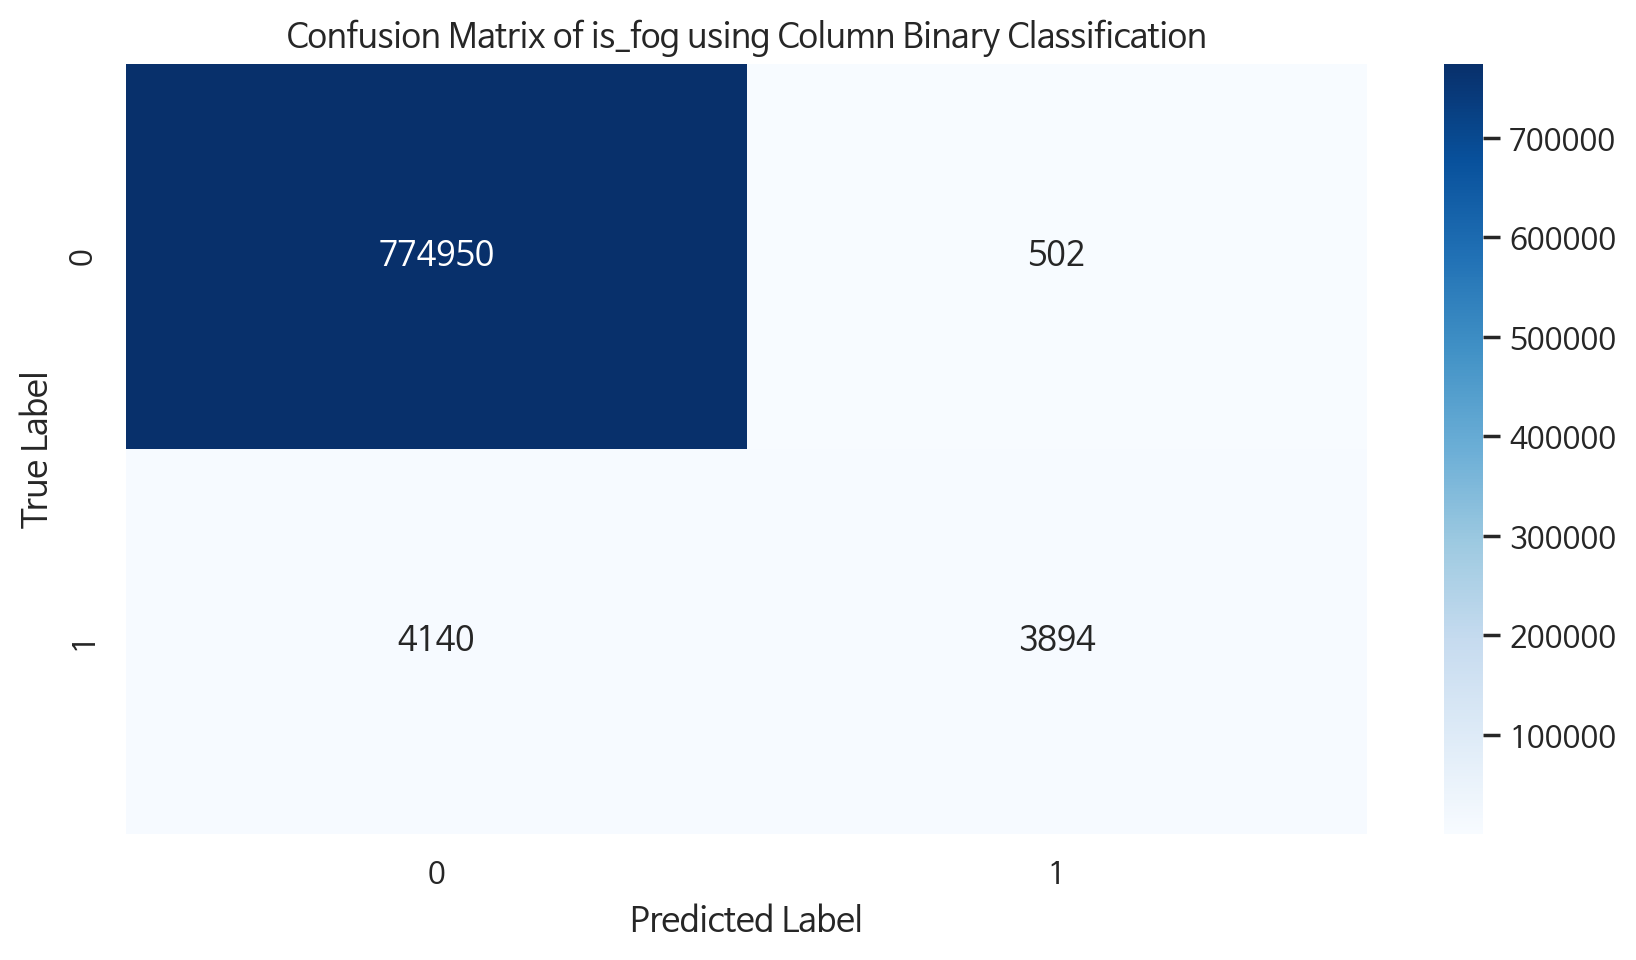

In [75]:
# Confusion Matrix 시각화

plt.figure(figsize=(10,5))

sns.heatmap(confusion_matrix(y_val_binary, y_val_pred_rf), 
            annot=True, 
            fmt="d", 
            cmap="Blues", 
)

plt.title(f'Confusion Matrix of is_fog using Column Binary Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

##### 3-3-1-2. 파생 컬럼 생성
- `class_predict` 컬럼 생성 
    - 이진 분류 모델로 예측한 안개 여부에 대한 값을 반영
    - 예측한 값 중, 0 (안개가 끼지 않았다)으로 나온 데이터의 `class_predict` 컬럼 값을 4 (안개가 끼지 않았다)로 지정
        - 이후 진행할 다중 분류 모델에 활용하기 위한 목적


In [64]:
# class_predict 컬럼 생성
# class_predict : 이진 분류로 예측한 안개 여부에 대한 값을 반영하기 위한 컬럼
# 이진 분류로 예측한 값 중, 0 (안개가 끼지 않았다)으로 나온 데이터의 class_predict 컬럼 값을 4 (안개가 끼지 않았다)로 지정
val_df.loc[y_val_pred_rf == 0, 'class_predict'] = 4
test_df.loc[y_test_pred_rf == 0, 'class_predict'] = 4

#### 3-3-2. 다중 분류 모델 개발

- 이진 분류를 통해 안개로 예측된 데이터들에 대해 **다중 분류**를 수행하여, `class`(**시정 계급**)를 예측한다.
    - X_데이터셋_binary와 X_데이터셋_mc는 동일한 데이터셋
    - 학습 데이터
        - X_train_cl : X_train_mc 데이터에서, 실제로 안개가 낀 데이터 (y_train_binary==1)만 필터링
        - y_train_cl : y_train_mc 데이터에서, 실제로 안개가 낀 데이터 (y_train_binary==1)만 필터링
    - 검증 및 예측 데이터
        - 이진 분류 모델을 통해, 안개가 낀다고 예측된 데이터의 index만을 필터링하여 예측 진행
            - 해당 필터링에 기반하여, X_val_cl, y_val_cl, X_test_cl 데이터셋 생성

In [67]:
# X_train에서 안개가 낀 데이터만을 필터링하여 학습 진행
X_train_cl = X_train_mc[y_train_binary == 1]
y_train_cl = y_train_mc[y_train_binary == 1]

# 이진 분류에서 안개로 예측된 데이터만을 필터링하여 예측 진행
rf_y_val_pred_idx = y_val_pred_rf[y_val_pred_rf == 1].index
rf_y_test_pred_idx = y_test_pred_rf[y_test_pred_rf == 1].index

X_val_cl = X_val_mc.loc[rf_y_val_pred_idx]
y_val_cl = y_val_mc.loc[rf_y_val_pred_idx]

X_test_cl = X_test_mc.loc[rf_y_test_pred_idx]

In [68]:
def class_rf_stn(X_train_cl, y_train_cl, X_val_cl, y_val_cl, X_test_cl):
    stn_list = range(1, 6)
    cm_cl = {}

    X_val_cl_sorted = X_val_cl.sort_values('stn_id')
    y_val_cl_sorted = y_val_cl.loc[X_val_cl_sorted.index]

    y_train_pred_df = pd.Series(index=X_train_cl.index, dtype=int)
    y_val_pred_df = pd.Series(index=X_val_cl.index, dtype=int)
    y_test_pred_df = pd.Series(index=X_test_cl.index, dtype=int)

    models = {i: RandomForestClassifier(random_state=42) for i in stn_list}
    columns = X_train_cl.columns

    for i in stn_list:
        # train
        now_idx_train = X_train_cl[X_train_cl['stn_id'] == i].index
        models[i].fit(X_train_cl.loc[now_idx_train, columns], y_train_cl.loc[now_idx_train])
        
        # validataion
        now_idx_val = X_val_cl_sorted[X_val_cl_sorted['stn_id'] == i].index
        if list(now_idx_val) == []:
            print(f"stn_id : {i}에 해당하는 값이 val 데이터셋에 없음")
            continue
        y_val_pred_now = models[i].predict(X_val_cl_sorted.loc[now_idx_val, columns])
        y_val_pred_df.loc[now_idx_val] = y_val_pred_now

        # test
        now_idx_test = X_test_cl[X_test_cl['stn_id'] == i].index
        if list(now_idx_test) == []:
            print(f"stn_id : {i}에 해당하는 값이 test 데이터셋에 없음")
            continue
        y_test_pred_now = models[i].predict(X_test_cl.loc[now_idx_test, columns])
        y_test_pred_df.loc[now_idx_test] = y_test_pred_now

        # confusion matrix 생성
        cm_cl[i] = confusion_matrix(y_val_cl_sorted[now_idx_val], y_val_pred_now)
        
    return y_val_pred_df, y_test_pred_df, cm_cl, models

In [69]:
y_val_pred_cl, y_test_pred_cl, cm_cl, models_cl = class_rf_stn(X_train_cl, y_train_cl, X_val_cl, y_val_cl, X_test_cl)

stn_id : 5에 해당하는 값이 test 데이터셋에 없음


##### 3-3-2-1. 다중 분류 모델 결과 및 시각화
- 다중 분류로 예측한 시정 계급을 `class_predict` 컬럼에 채워 넣는다.
    - 이를 바탕으로, 분류 모델에 대한 `confusion_matrix` 확인

In [72]:
val_df.loc[y_val_pred_cl.index, 'class_predict'] = y_val_pred_cl
test_df.loc[y_test_pred_cl.index, 'class_predict'] = y_test_pred_cl

In [73]:
cm = confusion_matrix(val_df["class"], val_df["class_predict"])
cm

array([[   941,    337,     25,    664],
       [   244,   1217,    246,   1315],
       [    37,    295,    552,   2161],
       [    50,    199,    253, 774950]], dtype=int64)

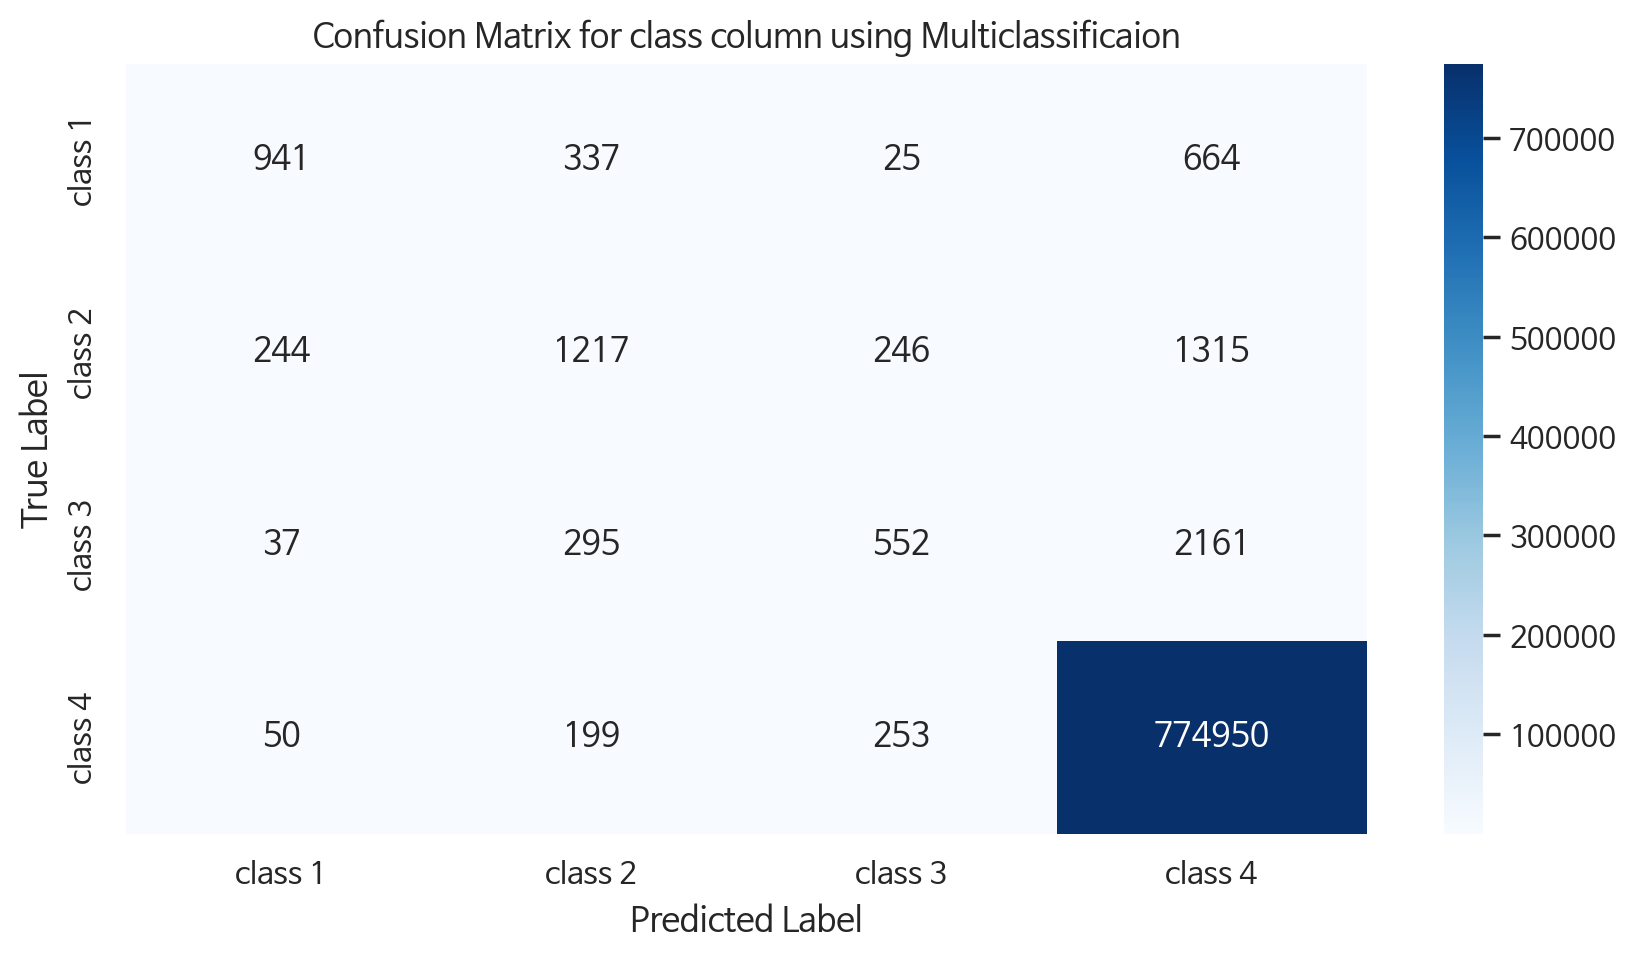

In [74]:
# Confusion Matrix 시각화

plt.figure(figsize=(10,5))

# target 컬럼 값들 unique_value에 선언
unique_value = np.unique(val_df["class_predict"], return_counts = False)

# Confusion Matrix에 label 표시하기 위해 "class" + value 합쳐준다
unique_value_list = []
for i, value in enumerate(unique_value):
    unique_value_list.append("class " + str(int(value)))


pred_labels = unique_value_list
sns.heatmap(cm, 
            annot=True, 
            fmt="d", 
            cmap="Blues", 
            xticklabels = pred_labels, 
            yticklabels = pred_labels)

plt.title(f'Confusion Matrix for class column using Multiclassificaion')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### 3-4. 모델 성능 확인

공모전 심사 기준인 **CSI Index**를 반영하여 모델의 성능을 평가한다.

In [76]:
csi_index(val_df["class"], val_df["class_predict"])

0.31747891283973756

In [77]:
test_df["class_predict"].value_counts()

class_predict
4.0    261758
2.0       793
3.0       178
1.0        71
Name: count, dtype: int64

In [78]:
# 공모전 제출을 위해, 예측한 값을 반영한 데이터셋 저장
# 다중 분류 모델을 바탕으로 test 데이터의 시정 계급 (class)을 예측한 값 : class_predict 컬럼에 반영
test_df.to_csv('data/240486.csv')

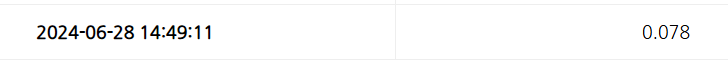

최종 제출 CSI Index는 **0.078**이다.